# Vibrational Analysis (from Gaussian FCHK with python)
In this tutorial notebook, we compute frequency, reduced mass and cartesian displacements for normal modes of vibration of a (relatively) big molecule, m22. 

The objective is to reproduce the normal modes information given in the $\texttt{.log}$ files of Gaussian output.

In [29]:
%matplotlib widget

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import scipy.linalg
import sys,os
import time

from ipywidgets import interact

sys.path.append("../")
import TOOLBOX as TLB
import CONSTANTS as CST

## Read input data from Gaussian calculation
The Gaussian package enables the generation of formated checkpoint files (.fchk) which are human-readable data outputs of the calculation.
Here, the first input file we look at is m22_opt-freq_S0.fchk, result of an optimization and frequency calculation in the ground state (DFT/cam-B3LYP/6-31+G* level of theory).

Here is a small script (to optimized at all) to do so.

In [2]:
with open("m22_opt-freq_S0.fchk","r") as f:
# with open("m22_opt-freq_S1_from-disp-TS.fchk","r") as f:
        lines=f.readlines()
        
coordinates=np.array([])
gradient=[]
hessianElements=[]
atomic_numbers=[]
atomic_masses=[]
# Go through the lines of the fchk
for i in range(len(lines)):
    line=lines[i].split()
    # Collect energy of the root state
    if len(line)>2 and line[0]=="Total" and line[1]=="Energy":
        ETot=float(line[-1])
        # Collect atomic numbers
        # Columns of 6 values
    if len(line)>2 and line[0]=="Atomic":
        NAtoms=int(line[-1])
        NCoords=3*NAtoms
        for p in range(NAtoms):
            atomic_numbers.append(lines[i+1+p//6].split()[p%6])
    # Collect atomic masses (in AMU)
    # Columns of 5 values
    if len(line)>2 and line[0]=="Real" and line[1]=="atomic":
        # NAtoms=int(line[-1])
        for p in range(NAtoms):
            atomic_masses.append(lines[i+1+p//5].split()[p%5])
    # Collect Cartesian Gradients (in atomic units, Hartree/bohr)
    # Columns of 5 values
    if len(line)>2 and line[0]=="Cartesian" and line[1]=="Gradient":
        # NCoords=int(line[-1])
        for p in range(NCoords):
            gradient.append(lines[i+1+p//5].split()[p%5])
    # Collect Cartesian, non-mass-weighted, Hessian (in atomic units, Hartree/bohr²)
    # Hessian is given in an triangular matrix form, with NElements=NCoords*(NCoords+1)/2 elements
    # Columns of 5 values
    if len(line)>2 and line[0]=="Cartesian" and line[1]=="Force":
        NElements=int(line[-1])
        for p in range(NElements):
            hessianElements.append(lines[i+1+p//5].split()[p%5])
    if len(line)>3 and line[1]=="cartesian" and line[2]=="coordinates":
        c=1
        while len(coordinates)!=NCoords:
            coordinates=np.append(coordinates,lines[i+c].split())
            c+=1
    coordinates=coordinates.astype(float) # in bohr, a_0

atomic_numbers=np.array(atomic_numbers).astype(str)
# Either use the atomic masses from fchk or atomic numbers
atomic_masses=np.array(atomic_masses).astype(float)
atomic_masses=np.array([[atomic_mass]*3 for atomic_mass in atomic_masses]).flatten()
gradient=np.array(gradient).astype(float)
hessianElements=np.array(hessianElements).astype(float)
# Build the upper triangular matrix
# By filling line by line
# First line and first column, first hessianElements...
# Second line and two first columuns, second and third hessianElements...
hessian=np.zeros((NCoords,NCoords))
Start=0
for p in range(NCoords):
    End=Start+p+1
    hessian[p,:p+1]=hessianElements[Start:End]
    Start=End
# Symmetrize the Hessian (not necessary with linal.eigh)
hessian=hessian+hessian.T-np.diag(np.diag(hessian))

print("NAtoms: {}".format(NAtoms))
print("NCoords: {}".format(NCoords))
print("Coordinates shape: {}".format(coordinates.shape),"in a_0")
print("Shape of the Gradient: {}".format(gradient.shape),"in E_h/a_0")
print("Shape of the Hessian: {}".format(hessian.shape),"in E_h/(a_0²)")

NAtoms: 36
NCoords: 108
Coordinates shape: (108,) in a_0
Shape of the Gradient: (108,) in E_h/a_0
Shape of the Hessian: (108, 108) in E_h/(a_0²)


Now, the quantities in the fchk are given in the system of cartesian coordinates in atomic units (bohr, a₀).
Before having the first information on the normal modes, the hessian in particular must be mass-weighted.

In [4]:
hessianInCartesian=np.copy(hessian)
atomicMasses=np.copy(atomic_masses)*CST.AMU_TO_ME
hessianInMWC=np.copy(hessianInCartesian)
for i in range(len(atomicMasses)):
    for j in range(len(atomicMasses)):
        hessianInMWC[i,j]=hessianInCartesian[i,j]/(np.sqrt(atomicMasses[i]*atomicMasses[j]))
print("Shape of the MW Hessian: {}".format(hessianInMWC.shape),"in E_h/(a_0²·m_e)")

Shape of the MW Hessian: (108, 108) in E_h/(a_0²·m_e)


From diagonalizing the MW Hessian, one can already obtain most of the information about the normal modes of the molecules, in particular frequencies and cartesian displacements of the modes of translation, rotation and vibration.

In [5]:
eigenvalues,diagonalizer=scipy.linalg.eigh(hessianInMWC)
normalModes=diagonalizer.T
print("Number of eigenvalues: {}".format(eigenvalues.shape))
print("Shape of the diagonalization matrix: {}".format(diagonalizer.shape))
print("Shape of the normal modes matrix: {}".format(normalModes.shape))

Number of eigenvalues: (108,)
Shape of the diagonalization matrix: (108, 108)
Shape of the normal modes matrix: (108, 108)


The eigenvalues are obtain in E_h/(a_0^2·m_e) and can be treated as mass-weighted curvatures $k_i \propto \omega_i^2$ where the conversion factor from E_h/(a_0^2·m_e) to cm⁻¹ is:

In [6]:
MWCurvature2Frequency=CST.HARTREE_TO_RCM

The eigenvalues can thus be converted to frequencies, but one must be careful with the negative eigenvalues that must be flagged with a negative sign, as in Gaussian. Note that at an optimized geometry for a minimum in the potential energy surface (PES), the first six frequencies must be numerically close to zero (exactly zero in theory). These frequencies are associated to the three translational modes and three rotational modes of the molecules and it is the subject of this tutorial to separate them from the (3N-6) vibrational modes.

In [8]:
negativeFrequencies=-CST.HARTREE_TO_RCM*np.sqrt(-eigenvalues[eigenvalues<0])
positiveFrequencies=CST.HARTREE_TO_RCM*np.sqrt(eigenvalues[eigenvalues>=0])
frequencies=np.append(negativeFrequencies,positiveFrequencies)
print(frequencies)

[-2.70166243e+00 -1.09199487e+00 -9.45092724e-01 -2.34997928e-02
  8.30156387e-03  3.62759581e-02  1.16389549e+01  1.31897522e+01
  1.86498970e+01  4.82895066e+01  5.09130094e+01  5.66833512e+01
  1.13719519e+02  1.37317711e+02  1.60859528e+02  1.73967259e+02
  2.27656998e+02  2.83507708e+02  2.96878912e+02  3.13232789e+02
  4.19285062e+02  4.19495269e+02  4.29590811e+02  4.40289189e+02
  4.45136492e+02  5.01042039e+02  5.15801691e+02  5.45292958e+02
  5.54636842e+02  5.64621075e+02  5.76765313e+02  5.94465850e+02
  5.97088677e+02  6.37388731e+02  6.42820432e+02  6.43547215e+02
  7.00194815e+02  7.13259398e+02  7.13413827e+02  7.14528842e+02
  7.54855446e+02  7.86774243e+02  7.87638412e+02  8.25124997e+02
  8.39927670e+02  8.73178868e+02  8.73262000e+02  9.41383232e+02
  9.47986236e+02  9.54386953e+02  9.54455734e+02  9.65933551e+02
  1.00655615e+03  1.00657014e+03  1.01778371e+03  1.02563936e+03
  1.02848318e+03  1.02850052e+03  1.02856507e+03  1.02867179e+03
  1.06786842e+03  1.06842

One can visualize displacement for instance for following one unity of a (for now normalized) normal mode of the molecule.
Note that this displacement is for now normalized and obtained from a mass-weighted system of coordinates, which might give different displacement than for a simple cartesian system of coordinates.

In [9]:
def visualizeDisplacement(initialCoordinates,displacement):
    initialCoordinates=initialCoordinates.reshape(NAtoms,3)
    maxCoordinates=np.max(initialCoordinates)
    displacement=displacement.reshape(NAtoms,3)
    fig=plt.figure()
    ax=fig.add_subplot(111,projection="3d")
    ax.scatter(initialCoordinates[:,0],initialCoordinates[:,1],initialCoordinates[:,2])
    ax.scatter(initialCoordinates[:,0]+displacement[:,0],initialCoordinates[:,1]+displacement[:,1],initialCoordinates[:,2]+displacement[:,2])
    ax.set_xlim(-maxCoordinates,maxCoordinates)
    ax.set_ylim(-maxCoordinates,maxCoordinates)
    ax.set_zlim(-maxCoordinates,maxCoordinates)
    plt.show()
    return fig

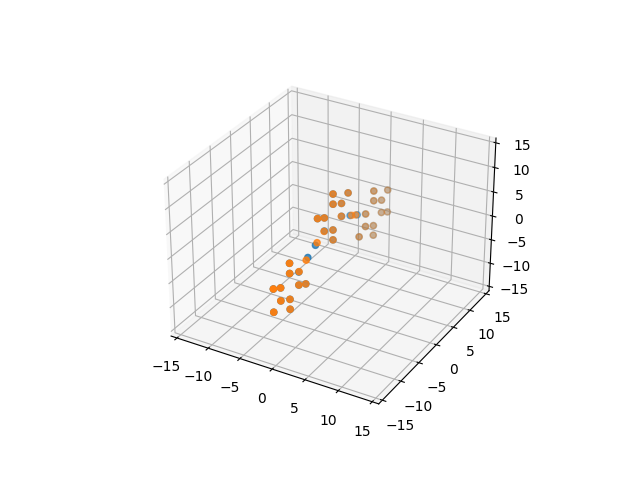

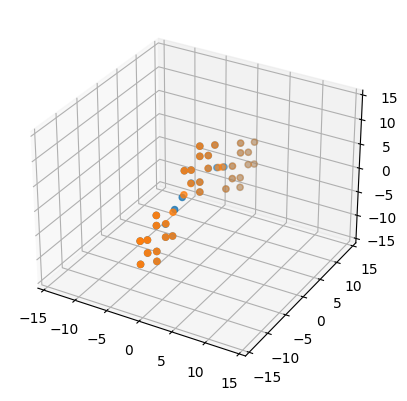

In [10]:
NMV=87
NMIndex=NMV-1+6 # Python counts from 0 to len(a): -1; there are six modes for Tr/Rot before the NMV
visualizeDisplacement(coordinates,normalModes[NMIndex])

Now, what if we only want the normal modes of __vibration__? We have to separate translational and rotational modes.
The modes of translation are easily defined:

In [11]:
# Generate coordinates in the translating and rotating frame
# Generate translational modes
D1=np.zeros(NCoords).reshape(NAtoms,3)
D1[:,0]=np.sqrt(atomicMasses.reshape(NAtoms,3))[:,0]
D1=D1.flatten()
D2=np.zeros(NCoords).reshape(NAtoms,3)
D2[:,1]=np.sqrt(atomicMasses.reshape(NAtoms,3))[:,1]
D2=D2.flatten()
D3=np.zeros(NCoords).reshape(NAtoms,3)
D3[:,2]=np.sqrt(atomicMasses.reshape(NAtoms,3))[:,2]
D3=D3.flatten()
# in a_0·sqrt(m_e)
# Normalize the translational modes
D1=D1/np.sqrt(np.sum(D1**2))
D2=D2/np.sqrt(np.sum(D2**2))
D3=D3/np.sqrt(np.sum(D3**2))

In [12]:
# Check for the center of mass of the molecule
centerOfMass=np.sum(atomicMasses.reshape(NAtoms,3)*coordinates.reshape(NAtoms,3),axis=0)/np.sum(atomicMasses.reshape(NAtoms,3))

The next three modes to define are the rotational modes associated to the molecule. They are defined making use of the inertia tensor and the coordinates of the molecule.

In [13]:
currentCoordinates=coordinates.reshape(NAtoms,3)
masses=atomicMasses.reshape(NAtoms,3)[:,0]
x=currentCoordinates[:,0]-centerOfMass[0]
y=currentCoordinates[:,1]-centerOfMass[1]
z=currentCoordinates[:,2]-centerOfMass[2]
inertiaTensor=np.array(
            [
                [
                    np.sum(masses*(y*y+z*z)),
                    -np.sum(masses*x*y),
                    -np.sum(masses*x*z)
                    ],
                [
                    -np.sum(masses*y*x),
                    np.sum(masses*(x*x+z*z)),
                    -np.sum(masses*y*z)
                    ],
                [
                    -np.sum(masses*z*x),
                    -np.sum(masses*z*y),
                    np.sum(masses*(x*x+y*y))
                    ]
                ]
                ) # a_0^2·m_e
eigenvaluesInertiaTensor,diagonalizerInertiaTensor=scipy.linalg.eigh(inertiaTensor)
print(eigenvaluesInertiaTensor)# à comparer avec constantes rotationnelles
principalMoments=eigenvaluesInertiaTensor
currentCoordinates=np.dot(currentCoordinates,diagonalizerInertiaTensor)
    
atomicMasses=atomicMasses.reshape(NAtoms,3)
D4=[]
D5=[]
D6=[]
for i in range(NAtoms):
    D4.append((currentCoordinates[i,1]*diagonalizerInertiaTensor[0,2]-currentCoordinates[i,2]*diagonalizerInertiaTensor[0,1])*np.sqrt(atomicMasses[i,0]))
    D4.append((currentCoordinates[i,1]*diagonalizerInertiaTensor[1,2]-currentCoordinates[i,2]*diagonalizerInertiaTensor[1,1])*np.sqrt(atomicMasses[i,0]))
    D4.append((currentCoordinates[i,1]*diagonalizerInertiaTensor[2,2]-currentCoordinates[i,2]*diagonalizerInertiaTensor[2,1])*np.sqrt(atomicMasses[i,0]))
    
    D5.append((currentCoordinates[i,2]*diagonalizerInertiaTensor[0,0]-currentCoordinates[i,0]*diagonalizerInertiaTensor[0,2])*np.sqrt(atomicMasses[i,0]))
    D5.append((currentCoordinates[i,2]*diagonalizerInertiaTensor[1,0]-currentCoordinates[i,0]*diagonalizerInertiaTensor[1,2])*np.sqrt(atomicMasses[i,0]))
    D5.append((currentCoordinates[i,2]*diagonalizerInertiaTensor[2,0]-currentCoordinates[i,0]*diagonalizerInertiaTensor[2,2])*np.sqrt(atomicMasses[i,0]))
    
    D6.append((currentCoordinates[i,0]*diagonalizerInertiaTensor[0,1]-currentCoordinates[i,1]*diagonalizerInertiaTensor[0,0])*np.sqrt(atomicMasses[i,0]))
    D6.append((currentCoordinates[i,0]*diagonalizerInertiaTensor[1,1]-currentCoordinates[i,1]*diagonalizerInertiaTensor[1,0])*np.sqrt(atomicMasses[i,0]))
    D6.append((currentCoordinates[i,0]*diagonalizerInertiaTensor[2,1]-currentCoordinates[i,1]*diagonalizerInertiaTensor[2,0])*np.sqrt(atomicMasses[i,0]))
D4=np.array(D4)
D5=np.array(D5)
D6=np.array(D6)
# Normalize the rotational modes
D4=D4/np.sqrt(np.sum(D4**2))
D5=D5/np.sqrt(np.sum(D5**2))
D6=D6/np.sqrt(np.sum(D6**2))
# Vérifier les constantes rotationnelles 

[ 5839006.98066793 40372665.48530715 46211672.46597508]


We now have defined the three translational and three rotational modes for the studied molecule. What we have to do now is to define a space of dimension $3\texttt{NAtoms}-6$ on which the mass-weighted Hessian will be projected. This space is orthogonal to the first six identified modes, such that the $3\texttt{NAtoms}-6$ remaining modes are separated from translation and rotation and can be thus called normal modes of __vibration__.

Here, we use a singular-value decomposition to produce the projector onto the complementary space of the first six normal modes. Another method is to construct iteratively the B matrix through a Scmidt orthogonalization, generating orthogonal vectors orthogonal to the first six modes. 

This matrix, B here but often called D in the literature, is the transformation matrix from mass-weithed cartesian coordinates to internal coordinates.

In [14]:
D=np.array([D1,D2,D3,D4,D5,D6]).T
U,s,V=scipy.linalg.svd(D,full_matrices=True)
B=U[:,6:]
    
vibHessianInMWC=np.dot(B.T,np.dot(hessianInMWC,B))

By projecting the Hessian onto the space generated by B, we transform the mass-weighted Hessian to a Hessian expressed in an internal coordinates system.
When diagonalizing this new Hessian, we obtained normal modes that are completely separated from translations and rotations (global modes) because the Hessian is expressed in the basis of internal coordinates (internal modes are found).

In [16]:
eigenvalues,diagonalizer=scipy.linalg.eigh(vibHessianInMWC)
# diagonalizer is lINT, NMV in cols expressed in the internal coordinates.
# thus normal modes have to be expressed in the MWC system again to be visualized.
normalModesVibration=np.dot(B,diagonalizer).T
negativeFrequencies=-CST.HARTREE_TO_RCM*np.sqrt(-eigenvalues[eigenvalues<0])
positiveFrequencies=CST.HARTREE_TO_RCM*np.sqrt(eigenvalues[eigenvalues>=0])
frequencies=np.append(negativeFrequencies,positiveFrequencies)
print(frequencies)

[  11.63659028   13.17466531   18.64989697   48.28946647   50.91298862
   56.68334999  113.71951879  137.3176787   160.85952276  173.9672528
  227.65699835  283.50770828  296.87891215  313.23278909  419.28506201
  419.49526903  429.59081089  440.28918924  445.13649155  501.04203861
  515.80169117  545.29295799  554.63684189  564.62107542  576.76531316
  594.46585021  597.08867707  637.38873094  642.82043227  643.54721458
  700.19481459  713.25939834  713.41382714  714.52884164  754.85544621
  786.77424331  787.63841207  825.12499712  839.92767027  873.17886779
  873.26200011  941.38323217  947.98623637  954.38695344  954.45573421
  965.93355093 1006.55614663 1006.57013886 1017.78370779 1025.63935931
 1028.48317633 1028.50052273 1028.56507124 1028.67179075 1067.8684243
 1068.42929175 1119.7741556  1119.77911444 1131.84862939 1160.13534476
 1196.51490678 1196.52139839 1199.35618917 1209.21816473 1218.44805587
 1219.59381638 1308.09359263 1329.94239731 1330.99315187 1331.20895356
 1362.12

Again, we can visualize the normal modes:

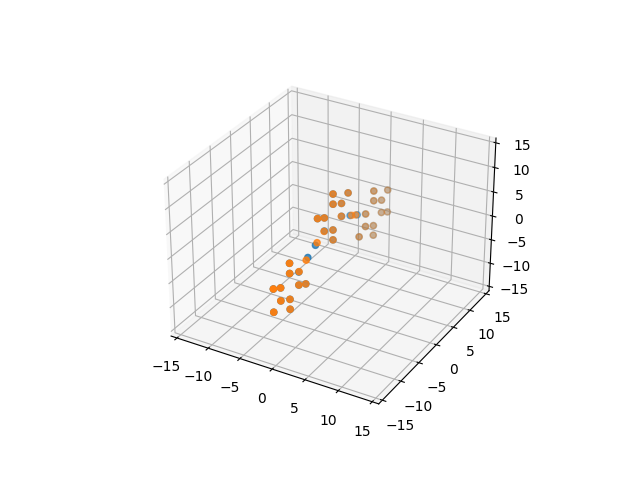

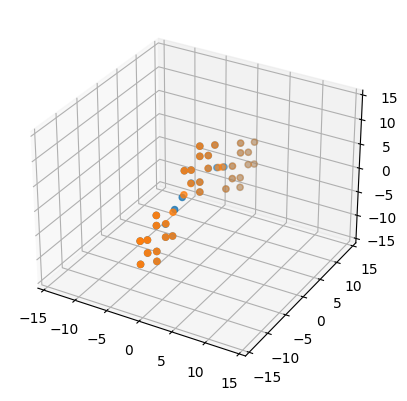

In [17]:
NMV=87
NMIndex=NMV-1 # Python counts from 0 to len(a): -1; the previous six modes for Tr/Rot before have been separated out of the NMV
visualizeDisplacement(coordinates,normalModesVibration[NMIndex])

We can do the same by treating simultaneously the translations, rotations and vibrations (but still with vibrations separeted). 
To do so, the full transformation matrix from mass-weighted coordinates to internal coordinates $D$ must be built.

In [18]:
D=np.array([D1,D2,D3,D4,D5,D6]).T
U,s,V=scipy.linalg.svd(D,full_matrices=True)
B=U[:,6:]
D=np.append(D,B,axis=1)
# D is the total transformation matrix from mass-weighted coordinates to internal coordinates.
# Note that the first 6 columns of D are the vectors relative to translations and rotations.

# Using D, one can transform the mass-weighted Hessian to the Hessian expressed in the internal coordinates
intHessian=np.dot(D.T,np.dot(hessianInMWC,D))

The eigenvalues of such a matrix can be converted to the usual frequencies in $\text{cm}^{-1}$, but the eigenvectors are difficult to directly use.
The matrix that diagonalize the Hessian in the internal coordinates system indeed contains the normal modes of vibration in its columns, but expressed in the internal coordinates system.
Thus, before being plotted as cartesian (mass-weighted or not) displacements, it must be transformed again.

In [20]:
eigenvalues,diagonalizer=scipy.linalg.eigh(intHessian)
# diagonalizer is lINT, NM in cols expressed in the internal coordinates.
# thus normal modes have to be expressed in the MWC system again to be visualized.
normalModesVibration=np.dot(D,diagonalizer).T
negativeFrequencies=-CST.HARTREE_TO_RCM*np.sqrt(-eigenvalues[eigenvalues<0])
positiveFrequencies=CST.HARTREE_TO_RCM*np.sqrt(eigenvalues[eigenvalues>=0])
frequencies=np.append(negativeFrequencies,positiveFrequencies)
print(frequencies)

[-2.70166243e+00 -1.09199487e+00 -9.45092724e-01 -2.34997857e-02
  8.30157492e-03  3.62759658e-02  1.16389549e+01  1.31897522e+01
  1.86498970e+01  4.82895066e+01  5.09130094e+01  5.66833512e+01
  1.13719519e+02  1.37317711e+02  1.60859528e+02  1.73967259e+02
  2.27656998e+02  2.83507708e+02  2.96878912e+02  3.13232789e+02
  4.19285062e+02  4.19495269e+02  4.29590811e+02  4.40289189e+02
  4.45136492e+02  5.01042039e+02  5.15801691e+02  5.45292958e+02
  5.54636842e+02  5.64621075e+02  5.76765313e+02  5.94465850e+02
  5.97088677e+02  6.37388731e+02  6.42820432e+02  6.43547215e+02
  7.00194815e+02  7.13259398e+02  7.13413827e+02  7.14528842e+02
  7.54855446e+02  7.86774243e+02  7.87638412e+02  8.25124997e+02
  8.39927670e+02  8.73178868e+02  8.73262000e+02  9.41383232e+02
  9.47986236e+02  9.54386953e+02  9.54455734e+02  9.65933551e+02
  1.00655615e+03  1.00657014e+03  1.01778371e+03  1.02563936e+03
  1.02848318e+03  1.02850052e+03  1.02856507e+03  1.02867179e+03
  1.06786842e+03  1.06842

Here, the information for the modes of translation and rotation are recovered with the first six eigenvalues and eigenvectors; the information for the normal modes of vibration are obtained with all the remaining values and vectors.
Again, we can visualize the results...

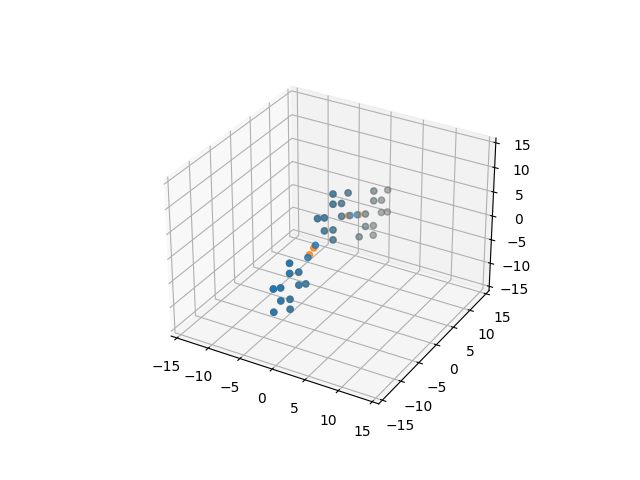

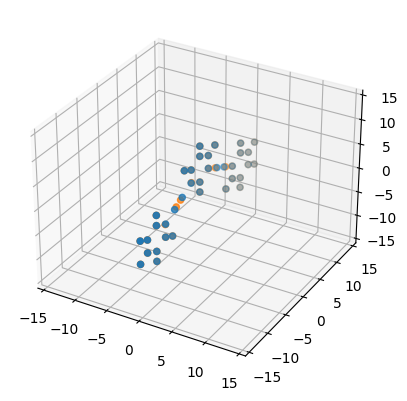

In [21]:
NMV=87
NMIndex=NMV-1+6 # Python counts from 0 to len(a): -1; the previous six modes for Tr/Rot before have been separated out of the NMV
visualizeDisplacement(coordinates,normalModesVibration[NMIndex])

### What about reduced masses? 
We are missing one crucial information here: what are the reduced masses of the computed normal modes of vibration? and of the modes of translation and rotation?

To obtain these values, we have to express the normal modes in the basis of the cartesian coordinates.
If we call $L$ the matrix that transforms the Hessian in the internal coordinates to the diagonalized matrix, we have $l_{\text{cart}}=MDL$, where D is the transformation matrix from mass-weighted cartesian coordinates to internal coordinates and M is the diagonal matrix containing the inverse of atomic masses.

In [23]:
M=np.diag(1/np.sqrt(atomicMasses.flatten()))

lCart=np.dot(M,np.dot(D,diagonalizer)) # diagonalizer is lINT, NM in cols expressed in the internal coordinates
renormalization=np.sqrt(1/np.sum(lCart**2,axis=0)) # sqrt(me)
reducedMasses=1/np.sum(lCart**2,axis=0)/CST.AMU_TO_ME # me -> amu
print("Renormalization (a.u.):\n",renormalization)
print("reducedMasses (AMU):\n",reducedMasses)
printedlCart=renormalization*lCart # Modes in the columns # was in sqrt(me)^{-1}, now in 1
printedModesCart=printedlCart.T # Modes in the rows

Renormalization (a.u.):
 [ 97.89196526 110.54447499 108.9705785  118.66775435 118.66926854
 118.66886028  81.68281971  84.79399421 103.15028031  93.31149805
  98.35561139 105.54057032 100.1398335   95.77941668  92.50538512
  97.449169   111.66348306 108.66611017  93.58819558  98.58276859
  72.58953217  72.53669224  80.11129594  92.01809727 124.13207467
 109.09975245  82.47611018 119.81884234 125.3510359  121.44754692
  84.29468252 114.1448881   92.76506705 107.43643174 109.65459669
 109.97524643 111.76630673  58.65051281  58.78469289  60.11679539
 108.03608347  56.82184719  57.15466715  52.49938054 109.23373685
  47.71160354  47.71088056  52.50740947  50.36207176  50.87854566
  50.91139158  88.40735362  49.99246221  49.99301497  49.57729915
 106.52915875  48.8540788   48.85582565 106.11794011 106.10321675
  63.14442871  62.15164614  52.99086002  52.98121787  55.1311959
  59.17033183  45.31330532  45.31383192  77.5593525   45.43606914
  45.29143987  46.45662871  69.58099389  84.01536283

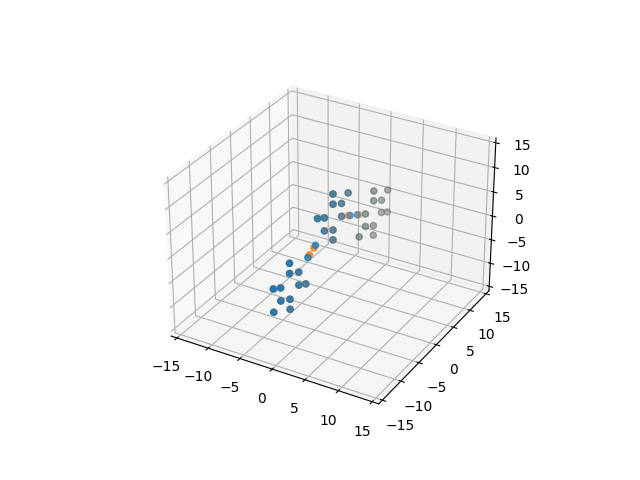

Printed by Gaussian:
 [-4.66969405e-11  1.37420322e-02 -9.33035837e-10 -2.42874397e-12
  5.86749318e-02 -3.92393410e-02 -3.47151153e-12  5.86749389e-02
  3.92393448e-02 -3.32646641e-11  5.60925384e-03 -4.82319136e-03
 -3.45623571e-11  5.60925401e-03  4.82319206e-03  3.34838778e-11
 -9.18744191e-03 -2.86633247e-10  1.46606815e-11 -6.26181541e-02
  3.62088365e-02  1.17009931e-11 -7.14681047e-03  6.74161128e-04
 -3.38261686e-11  4.15449888e-03 -3.07542702e-03  1.14810570e-12
 -1.56550192e-03  9.03906285e-04  4.40348428e-12  4.74348200e-03
 -2.05708407e-03 -1.61948441e-11 -4.15022635e-03  5.85625105e-03
 -3.80284453e-11  4.28434406e-01 -2.46875838e-01  2.11565623e-11
 -4.28728006e-01  2.47071577e-01  1.25370509e-11 -6.26181610e-02
 -3.62088404e-02  1.38042357e-11 -7.14681105e-03 -6.74161252e-04
 -3.52634092e-11  4.15449922e-03  3.07542740e-03  3.97313795e-12
 -1.56550196e-03 -9.03906558e-04  1.78042500e-12  4.74348239e-03
  2.05708440e-03 -1.46780944e-11 -4.15022675e-03 -5.85625174e-03
 -3

In [24]:
NMV=87
NMIndex=NMV-1+6 # Python counts from 0 to len(a): -1; the previous six modes for Tr/Rot before have been separated out of the NMV
#visualizeDisplacement(coordinates,normalModesCart[NMIndex])
visualizeDisplacement(coordinates,printedModesCart[NMIndex])
print("Printed by Gaussian:\n",printedModesCart[NMIndex])

In [25]:
def visualizeNormalMode(initialCoordinates,normalMode,atomicNumbers=None,scale=1,projection="3d"):
    atom_colors={}
    atom_colors["1"]="gray"
    atom_colors["H"]="gray"
    atom_colors["6"]="black"
    atom_colors["C"]="black"
    atom_colors["8"]="red"
    atom_colors["O"]="red"
    initialCoordinates=initialCoordinates.reshape(NAtoms,3)
    maxCoordinates=np.max(initialCoordinates)
    normalMode=normalMode.reshape(NAtoms,3)
    fig=plt.figure()
    if projection=="3d":
        ax=fig.add_subplot(111,projection=projection)
    else:
        ax=fig.add_subplot(111)
    if atomicNumbers is None:
        ax.scatter(initialCoordinates[:,0],initialCoordinates[:,1],initialCoordinates[:,2])
    else:
        for atomType in set(atomicNumbers):
            atomSelection=(atomicNumbers==atomType)
            ax.scatter(initialCoordinates[atomSelection,0],initialCoordinates[atomSelection,1],initialCoordinates[atomSelection,2],color=atom_colors[str(atomType)])
    
    normalModeVectors=normalMode/np.max(np.sqrt(np.sum(normalMode**2,axis=1)))
    normalModeVectors*=scale
    ax.quiver(initialCoordinates[:,0],initialCoordinates[:,1],initialCoordinates[:,2],
              normalModeVectors[:,0],normalModeVectors[:,1],normalModeVectors[:,2],
             )
    ax.set_xlim(-maxCoordinates,maxCoordinates)
    ax.set_ylim(-maxCoordinates,maxCoordinates)
    ax.set_zlim(-maxCoordinates,maxCoordinates)
    return fig,ax

In [26]:
def plotInt(NMV='#{}, ω={}, μ={}'.format(87,np.round(frequencies[87+5],2),np.round(reducedMasses[87+5],2)),scale=1.5):
    if NMV is not int:
        NMV=int(NMV.split(",")[0][1:])
    NMIndex=NMV-1+6
    fig,ax=visualizeNormalMode(coordinates,printedModesCart[NMIndex],atomic_numbers,scale=scale)
    ax.view_init(elev=0, azim=0, roll=0)
    plt.axis('off')
    plt.show()
modes=['#{}, ω={}, μ={}'.format(_,np.round(frequencies[_+5],2),np.round(reducedMasses[_+5],2)) for _ in range(-5,3*NAtoms-6+1)]
#interact(plotInt,NMV=(-5,3*NAtoms-6),scale=(-2.5,2.5,0.25))
interact(plotInt,NMV=modes,scale=(-2.5,2.5,0.25))

interactive(children=(Dropdown(description='NMV', index=92, options=('#-5, ω=-2.7, μ=5.26', '#-4, ω=-1.09, μ=6…

<function __main__.plotInt(NMV='#87, ω=2366.54, μ=12.0', scale=1.5)>

## Check Orthogonality
Now, let us look at the orthogonality properties of the normal modes previously obtained.
We have to types of normal modes: 
- "mass-weighted" displacements normal modes (i);
- cartesian displacements normal modes (ii).

The first are obtained either by:
- diagonalization of the mass-weighted Hessian
- diagonalization of the mass-weighted Hessian expressed in the internal coordinates system, with re-transformation of the eigenvectors from internal coordinates to mass-weihted coordinates

The cartesian displacements are obtained by removing the mass-weighting from the latter displacements and re-normalize it with the reduced masses.

We expect the mass-weigthed displacemnts to be orthogonal and not the cartesian displacements.

First, let us define a visualization function for plotting the overlap matrix between a set of vectors.

In [27]:
def visualizeOrthogonality(matrixVectors):
    fig=plt.figure()
    ax=fig.add_subplot(111)
    ap=ax.imshow(np.dot(matrixVectors,matrixVectors.T),cmap="cividis")
    divider=make_axes_locatable(ax)
    colorbar_axes=divider.append_axes("right",size="5%",pad=0.1)
    plt.colorbar(ap,cax=colorbar_axes)
    fig.tight_layout()
    plt.show()

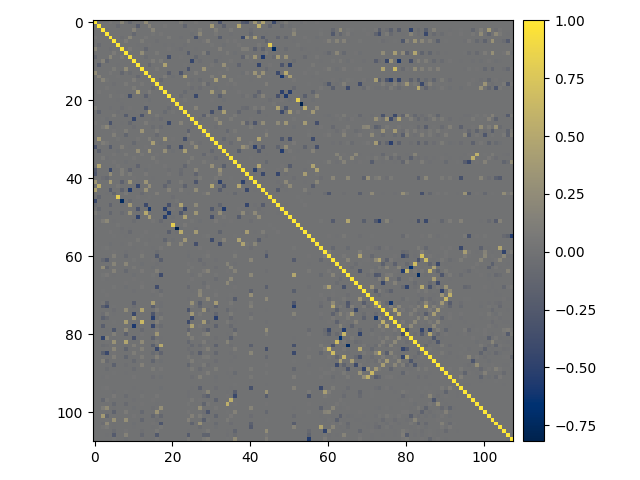

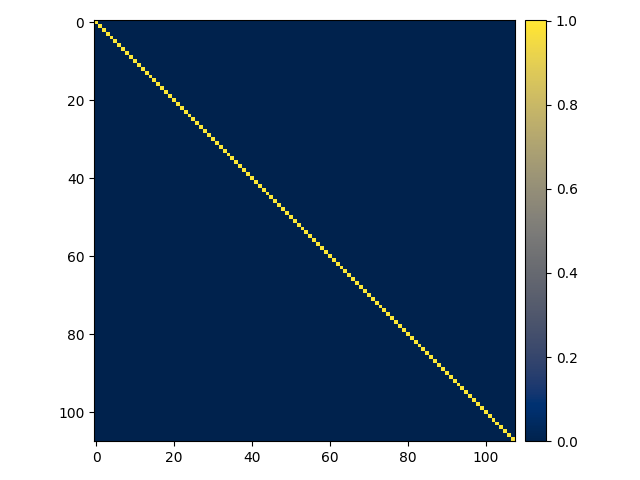

In [28]:
visualizeOrthogonality(printedModesCart)
visualizeOrthogonality(normalModesVibration)